# Regression Models

In [119]:
import sys
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [223]:
def get_features_and_labels(frame, test_frame):
    '''
    Transforms and scales the input data and returns numpy arrays for
    training and testing inputs and targets.
    '''

    # Convert values to floats
    arr = np.array(frame, dtype=np.float)
    test_arr = np.array(test_frame, dtype=np.float)
    
    # Use the last column as the target value
    X, y = arr[:, :-1], arr[:, -1]
    X_test = test_arr
    
    # Use 85% of the data for training,  but cross validate over the entire dataset.
    from sklearn.model_selection import train_test_split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15)
    #X_val = X
    #y_val = y
    
    # If values are missing we could impute them from the training data
    #from sklearn.preprocessing import Imputer
    #imputer = Imputer(strategy='mean')
    #imputer.fit(X_train)
    #X_train = imputer.transform(X_train)
    #X_test = imputer.transform(X_test)
    
    # Normalize the attribute values to mean=0 and variance=1
    from sklearn.preprocessing import StandardScaler
    scaler = StandardScaler()
    
    # Fit the scaler based on the training data, then apply the same
    # scaling to both training and test sets.
    scaler.fit(X_train)
    X_train = scaler.transform(X_train)
    X_val = scaler.transform(X_val)
    
    scaler.fit(X_test)
    X_test = scaler.transform(X_test)

    # Return the training and test sets
    return X_train, X_val, y_train, y_val, X_test

In [109]:
class DisplayLossCurve(object):
    def __init__(self, print_loss=False, title=None):
        self.print_loss = print_loss
        self.title = title
    """Make sure the model verbose is set to 1"""
    def __enter__(self):
        self.old_stdout = sys.stdout
        sys.stdout = self.mystdout = io.StringIO()
  
    def __exit__(self, *args, **kwargs):
        sys.stdout = self.old_stdout
        loss_history = self.mystdout.getvalue()
        loss_list = []
        for line in loss_history.split('\n'):
            if(len(line.split("loss: ")) == 1):
                continue
            loss_list.append(float(line.split("loss: ")[-1]))
        plt.figure()
        plt.plot(np.arange(len(loss_list)), loss_list)
        plt.title(self.title)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")

        if self.print_loss:
            print("=============== Loss Array ===============")
            print(np.array(loss_list))
      
        return True

In [113]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit


def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    
    if axes is None:
        _, axes = plt.subplots(1, 2, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    
    # Plot fit_time vs score
    axes[1].grid()
    axes[1].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[1].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[1].set_xlabel("fit_times")
    axes[1].set_ylabel("Score")
    axes[1].set_title("Performance of the model")
    
    plt.show()
    
    return estimator

In [366]:
def evaluate_learner(X_train, X_val, y_train, y_val, X_test, learning_curves=False):
    '''
    Run multiple times with different algorithms to get an idea of the
    relative performance of each configuration.

    Returns a sequence of tuples containing:
        (title, expected values, actual values)
    for each learner.
    '''
    '''
    #Use a linear regression model
    from sklearn.linear_model import LinearRegression
    
    lreg = LinearRegression()
    if learning_curves:
        plot_learning_curve(lreg, 'Linear Regression Model', X_train, y_train, axes=None, ylim=None, cv=None,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    
    lreg.fit(X_train, y_train)
    y_pred = lreg.predict(X_val)
    pred = lreg.predict(X_test)
    r_2 = lreg.score(X_val, y_val)
    yield 'Linear Regression Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    # Use stochastic gradient descent for regression
    from sklearn.linear_model import SGDRegressor

    # Train using a squared loss function
    sgd = SGDRegressor(loss='squared_loss', penalty='l2', verbose=1)
    if learning_curves:
        plot_learning_curve(sgd, 'SGD Squared Loss Model', X_train, y_train, axes=None, ylim=None, cv=None,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    with DisplayLossCurve(title='SGD Squared Loss Model'):
        sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_val)
    pred = sgd.predict(X_test)
    r_2 = sgd.score(X_val, y_val)
    yield 'SGD Squared Loss Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred

    # Train using a huber loss function
    sgd = SGDRegressor(loss='squared_epsilon_insensitive', penalty='l2', verbose=1)
    if learning_curves:
        plot_learning_curve(sgd, 'SGD Epsilon Insensitive Loss Model', X_train, y_train, axes=None, ylim=(-1,1), cv=None,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    with DisplayLossCurve(title='SGD Epsilon Insensitive Loss Model'):
        sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_val)
    pred = sgd.predict(X_test)
    r_2 = sgd.score(X_val, y_val)
    yield 'SGD Epsilon Insensitive Loss Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred

    # Train using a squared loss function with l1 penalty
    sgd = SGDRegressor(loss='squared_loss', penalty='elasticnet', verbose=1)
    if learning_curves:
        plot_learning_curve(sgd, 'SGD Squared Loss l1 Model', X_train, y_train, axes=None, ylim=(-1,1), cv=None,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    with DisplayLossCurve(title='SGD Squared Loss elasticnet Model'):
        sgd.fit(X_train, y_train)
    y_pred = sgd.predict(X_val)
    pred = sgd.predict(X_test)
    r_2 = sgd.score(X_val, y_val)
    yield 'SGD Squared Loss elasticnet Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred

    #Using ElasticNet for regression
    from sklearn.linear_model import ElasticNet
    eln = ElasticNet(alpha=5, selection='cyclic')
    if learning_curves:
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
        plot_learning_curve(eln, 'ElasticNetr Model', X_train, y_train, axes=None, ylim=(-1,1.01), cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    
    eln.fit(X_train, y_train)
    y_pred = eln.predict(X_val)
    pred = eln.predict(X_test)
    r_2 = eln.score(X_val, y_val)
    yield 'ElacticNet Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    #Using Lasso for regression 
    from sklearn.linear_model import Lasso
    las = Lasso(alpha=5, selection='cyclic')
    if learning_curves:
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
        plot_learning_curve(las, 'Lasso Model', X_train, y_train, axes=None, ylim=(-1,1.01), cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    
    las.fit(X_train, y_train)
    y_pred = las.predict(X_val)
    pred = las.predict(X_test)
    r_2 = las.score(X_val, y_val)
    yield 'Lasso Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    X = np.concatenate((X_train, X_val))
    y = np.concatenate((y_train, y_val))
    
    #Using Ridge for regression
    from sklearn.linear_model import Ridge
    
    #Using Auto Solver
    rid = Ridge(solver='auto', alpha=5)
    if learning_curves:
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
        plot_learning_curve(rid, 'Ridge Auto Solver Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    
    rid.fit(X_train, y_train)
    y_pred = rid.predict(X_val)
    pred = rid.predict(X_test)
    r_2 = rid.score(X_val, y_val)
    yield 'Ridge Auto Solver Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    #Using Saga Solver
    rid = Ridge(solver='saga', alpha=5)
    if learning_curves:
        cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)
        plot_learning_curve(rid, 'Ridge Saga Solver Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5))
    
    rid.fit(X_train, y_train)
    y_pred = rid.predict(X_val)
    pred = rid.predict(X_test)
    r_2 = rid.score(X_val, y_val)
    yield 'Ridge Saga Solver Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    '''
    # Using a Random Forest model for regression
    from sklearn.ensemble import RandomForestRegressor
    
    rfreg = RandomForestRegressor(n_estimators=500, min_samples_split=5)
    if learning_curves:
        cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
        plot_learning_curve(rfreg, 'RandomForest Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
        
    rfreg.fit(X_train, y_train)
    y_pred = rfreg.predict(X_val)
    pred = rfreg.predict(X_test)
    r_2 = rfreg.score(X_val, y_val)
    yield 'RandomForest Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred

In [333]:
def gb_models(X_train, X_val, y_train, y_val, X_test, learning_curves=False):
    
    X = np.concatenate((X_train, X_val))
    y = np.concatenate((y_train, y_val))
    
    #Using Xgboost model
    from xgboost import XGBRegressor
    
    xgbr = XGBRegressor()
    if learning_curves:
        cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
        plot_learning_curve(xgbr, 'XGBoost Regressor Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    xgbr.fit(X_train, y_train)
    y_pred = xgbr.predict(X_val)
    pred = xgbr.predict(X_test)
    r_2 = xgbr.score(X_val, y_val)
    yield 'XGBoost Regressor Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    #Using lightgbm model
    from lightgbm import LGBMRegressor
    
    lgbmr = LGBMRegressor(boosting_type='dart')#, learning_rate=1, reg_lambda=0.001, n_estimators=200)
    if learning_curves:
        cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
        plot_learning_curve(lgbmr, 'LightGBM Regressor Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    lgbmr.fit(X_train, y_train)
    y_pred = lgbmr.predict(X_val)
    pred = lgbmr.predict(X_test)
    r_2 = lgbmr.score(X_val, y_val)
    yield 'LightGBM Regressor Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred
    
    #Using catboost model
    from catboost import CatBoostRegressor, Pool
    
    eval_set = Pool(X_val, y_val)
    cbr = CatBoostRegressor(verbose=0)
    if learning_curves:
        cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
        plot_learning_curve(cbr, 'Catboost Regressor Model', X, y, axes=None, ylim=(0.8,1.01), cv=cv,
                            n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5))
    cbr.fit(X_train, y_train)
    y_pred = cbr.predict(X_val)
    pred = cbr.predict(X_test)
    r_2 = cbr.score(X_val, y_val)
    yield 'Catboost Regressor Model ($R^2={:.3f}$)'.format(r_2), y_val, y_pred, pred

In [247]:
def plot(results):
    '''
    Create a plot comparing multiple learners.

    `results` is a list of tuples containing:
        (title, expected values, actual values)
    
    All the elements in results will be plotted.
    '''

    # Using subplots to display the results on the same X axis
    fig, plts = plt.subplots(nrows=len(results), figsize=(14, 8))
    fig.canvas.set_window_title('Predicting Housing Prices')

    # Show each element in the plots returned from plt.subplots()
    for subplot, (title, y, y_pred, pred) in zip(plts, results):
        # Configure each subplot to have no tick marks
        # (these are meaningless for the sample dataset)
        subplot.set_xticklabels(())
        subplot.set_yticklabels(())

        # Label the vertical axis
        subplot.set_ylabel('house price')

        # Set the title for the subplot
        subplot.set_title(title)

        # Plot the actual data and the prediction
        subplot.plot(y, 'b', label='actual')
        subplot.plot(y_pred, 'r', label='predicted', alpha=0.5)
        
        # Shade the area between the predicted and the actual values
        subplot.fill_between(
            # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
            np.arange(0, len(y), 1),
            y,
            y_pred,
            color='r',
            alpha=0.2
        )

        # Mark the extent of the training data
        subplot.axvline(len(y) // 2, linestyle='--', color='0', alpha=0.2)

        # Include a legend in each subplot
        subplot.legend()

    # Let matplotlib handle the subplot layout
    fig.tight_layout()

    # ==================================
    # Display the plot in interactive UI
    plt.show()

    # To save the plot to an image file, use savefig()
    #plt.savefig('plot.png')

    # Open the image file with the default image viewer
    #import subprocess
    #subprocess.Popen('plot.png', shell=True)

    # To save the plot to an image in memory, use BytesIO and savefig()
    # This can then be written to any stream-like object, such as a
    # file or HTTP response.
    #from io import BytesIO
    #img_stream = BytesIO()
    #plt.savefig(img_stream, fmt='png')
    #img_bytes = img_stream.getvalue()
    #print('Image is {} bytes - {!r}'.format(len(img_bytes), img_bytes[:8] + b'...'))

    # Closing the figure allows matplotlib to release the memory used.
    plt.close()



In [205]:
frame  = pd.read_csv('train_cleaned.csv')
test_frame = pd.read_csv('test_cleaned.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)

Processing 1460 samples with 175 attributes


Evaluating regression learners...


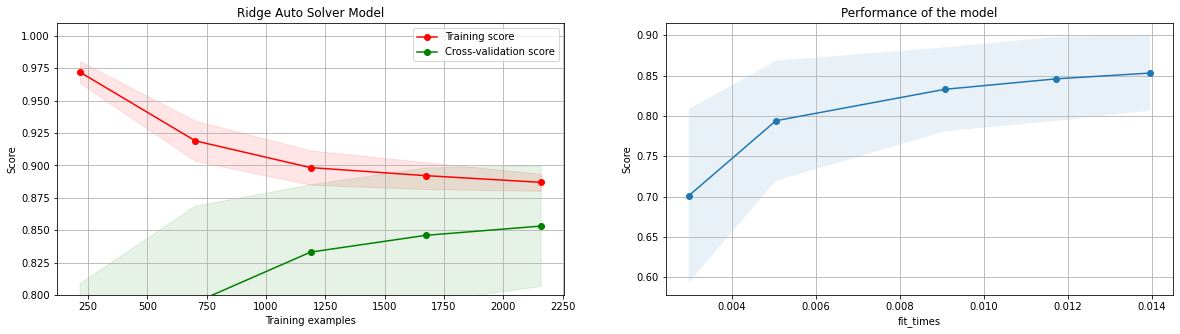

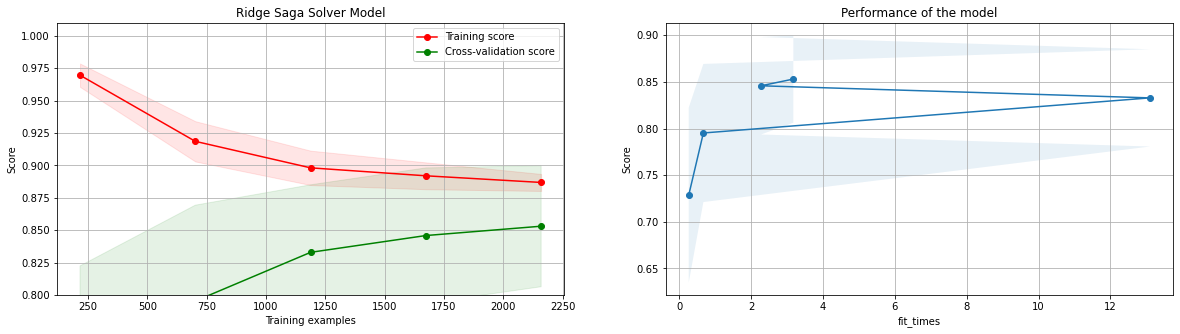

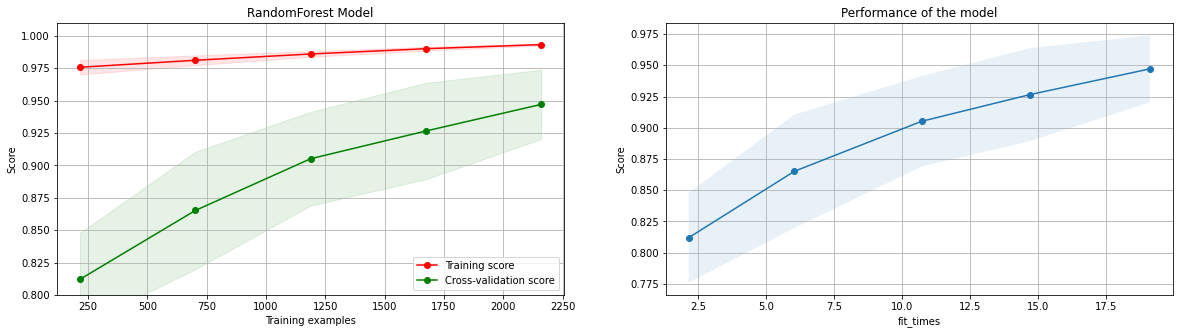

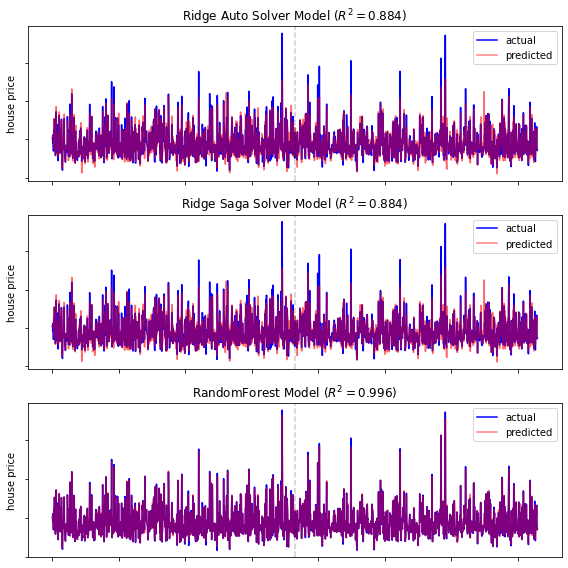

In [206]:
# Evaluate multiple regression learners on the data
print("Evaluating regression learners...")
results = list(evaluate_learner(X_train, X_val, y_train, y_val, X_test, learning_curves=True))

# Display the results
#print("Plotting the results")
plot(results)

In [210]:
i = 0
for title, y, y_pred, pred in results:
    if i == 2:
        output['SalePrice'] = pred
    i+=1

In [211]:
output.to_csv('submission7.csv', index = False)

# Score = 0.15012 ---> 0.14614 ---> 0.14509 ---> 0.12992 ---> 0.12868 ---> 0.12702

In [192]:
frame  = pd.read_csv('train_featured.csv')
test_frame = pd.read_csv('test_featured.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)

Processing 1460 samples with 153 attributes


Evaluating regression learners...
Plotting the results


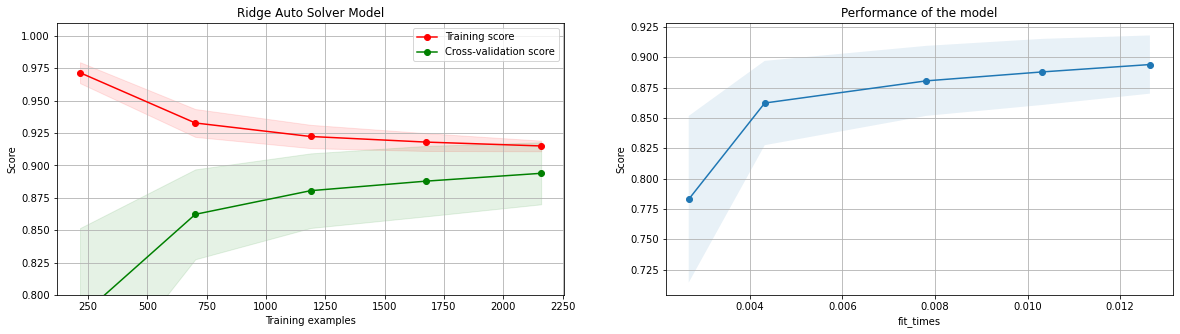

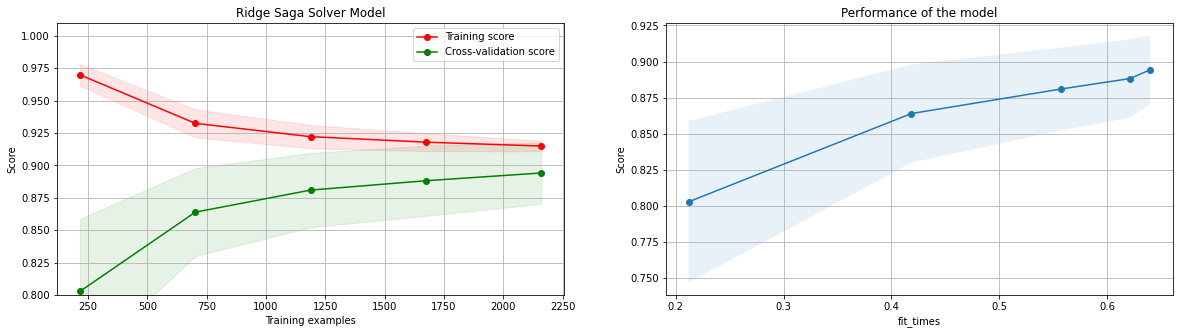

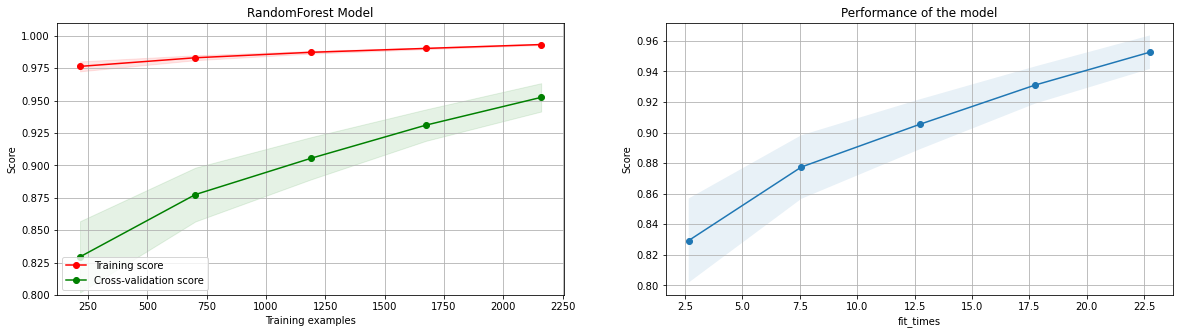

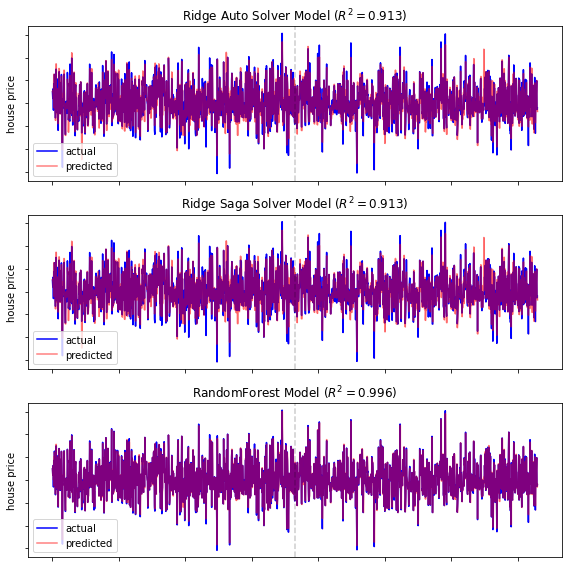

In [200]:
# Evaluate multiple regression learners on the data
print("Evaluating regression learners...")
print("Plotting the results")
results = list(evaluate_learner(X_train, X_val, y_train, y_val, X_test, learning_curves=True))

# Display the results
plot(results)

In [202]:
i = 0
for title, y, y_pred, pred in results:
    if i == 2:
        output['SalePrice'] = pred
    i+=1

In [203]:
output['SalePrice'] = np.exp(output.SalePrice)

In [204]:
output.to_csv('submission6.csv', index=False)

In [249]:
frame  = pd.read_csv('train_featured.csv')
test_frame = pd.read_csv('test_featured.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)

Processing 1460 samples with 153 attributes


Evaluating regression learners...
Plotting the results


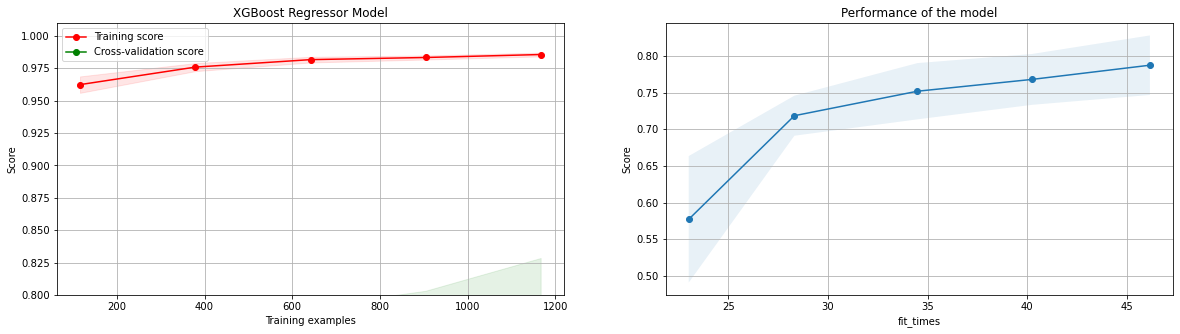

[17:43:53] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:573: 
Parameters: { "sub_sample" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


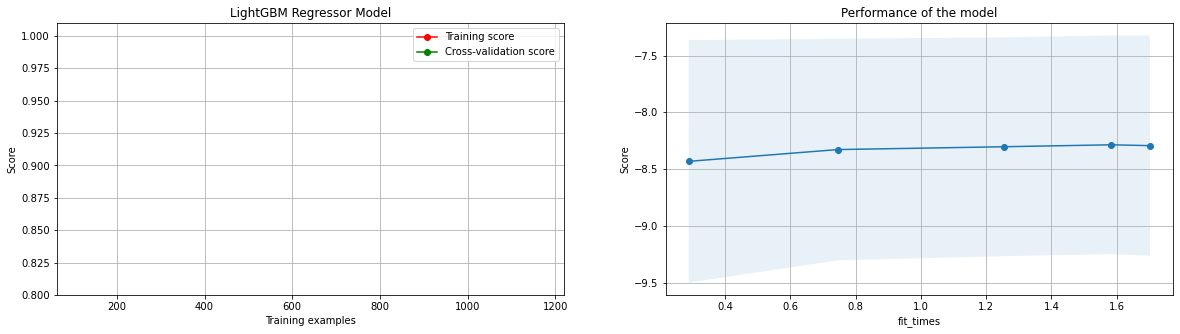

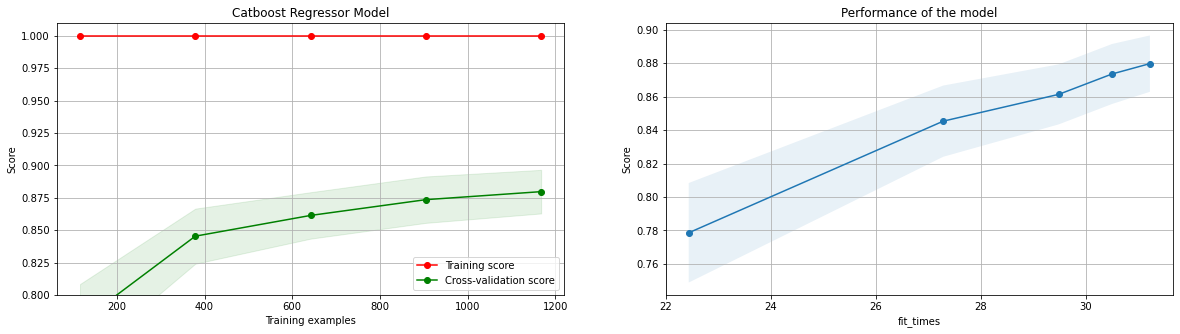

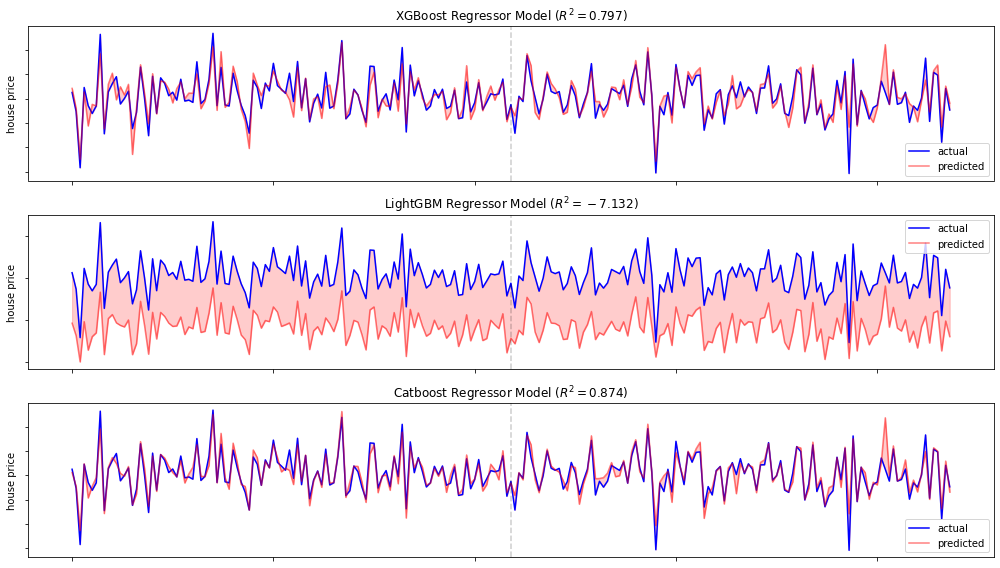

In [256]:
# Evaluate multiple regression learners on the data
print("Evaluating regression learners...")
print("Plotting the results")
results = list(gb_models(X_train, X_val, y_train, y_val, X_test, learning_curves=True))

# Display the results
plot(results)

In [244]:
i = 0
for title, y, y_pred, pred in results:
    if i == 2:
        output['SalePrice'] = pred
    i+=1

In [245]:
output['SalePrice'] = np.exp(output.SalePrice)

In [246]:
output.to_csv('Submission8.csv', index=False)

# Stacking Regression

In [259]:
from sklearn.linear_model import LinearRegression, ElasticNetCV, LassoCV, RidgeCV
from sklearn.ensemble import IsolationForest,GradientBoostingRegressor
from sklearn.model_selection import ShuffleSplit, GridSearchCV
from mlxtend.regressor import StackingCVRegressor,StackingRegressor
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor

In [275]:
models={}
#Reading data
frame  = pd.read_csv('train_featured.csv')
test_frame = pd.read_csv('test_featured.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)


Processing 1460 samples with 153 attributes


## Linear Models

### Linear Regression

In [276]:
name = 'linear'
models[name] = LinearRegression()
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Linear Regression: R^2={:.3f}'.format(r_2))

Linear Regression: R^2=0.906


### LassoCV Regression

In [278]:
name = 'lassocv'
grid = {"alphas":np.arange(0.0001,0.001,0.00001)}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = LassoCV(cv=cv, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('LassoCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 0.00099
LassoCV Regression: R^2=0.910


### RidgeCV Regression

In [282]:
name = 'ridgecv'
grid = {"alphas":np.arange(2,2.2,0.001)}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = RidgeCV(cv=cv, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('RidgeCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 2.199999999999978
RidgeCV Regression: R^2=0.906


### ElasticNet Regression

In [283]:
name = 'elasticnetcv'
grid = {"alphas" : np.arange(0.0001,0.001,0.00005),
         "l1_ratio" : [.1, .5, .7, .9, .95, .96, .97,.98, .99, 1]}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = ElasticNetCV(cv=cv, max_iter=1e5, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('ElasticNetCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 0.0009500000000000002
ElasticNetCV Regression: R^2=0.910


### Linear Mixture Regression

In [285]:
name = "lin_mix"
names = ["elasticnetcv","ridgecv","lassocv","linear"]
models[name] = StackingCVRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=CatBoostRegressor(verbose=False),
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Linear Mixture Regression: R^2={:.3f}'.format(r_2))

Linear Mixture Regression: R^2=0.927


## Advance Regression Models

### RandomForest Regression

In [292]:
name = 'randomforest'
models[name] = RandomForestRegressor(n_estimators=500)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Random Forest Regression: R^2={:.3f}'.format(r_2))

Random Forest Regression: R^2=0.877


### GradientBoostingRegressor

In [294]:
name = 'sk_gbr'
params = {'learning_rate': 0.06700000000000003,'max_depth': 5,'min_samples_leaf': 5,'min_samples_split': 15,'subsample': 0.1}
models[name] = GradientBoostingRegressor(verbose=False,random_state=0, loss='huber', **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Gradient Boosting Regression: R^2={:.3f}'.format(r_2))

Gradient Boosting Regression: R^2=0.900


### LightGBM Regression

In [295]:
name = 'lightgbm'
params = {'learning_rate': 0.018999999999999996,'min_child_samples': 20,'min_split_gain': 0,
          'n_estimators': 500,'reg_alpha': 0.03,'reg_lambda': 0.02,'subsample': 1}
models[name] = LGBMRegressor(silent=True, random_state=0, max_depth=-1, **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('LightGBM Regression: R^2={:.3f}'.format(r_2))

LightGBM Regression: R^2=0.882


### XGBoost Regression

In [296]:
name = 'xgboost'
params = {'learning_rate': 0.02299,'max_depth': 6,'n_estimators': 500,'reg_alpha': 0.001,'reg_lambda': 0.41,'subsample': 0.5}
models[name] = XGBRegressor(random_state=0, **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('XGBoost Regression: R^2={:.3f}'.format(r_2))

XGBoost Regression: R^2=0.915


### CatBoost Regression

In [297]:
name = 'catboost'
params = {'learning_rate': 0.02299,'max_depth': 6,'n_estimators': 500,'reg_alpha': 0.001,'reg_lambda': 0.41,'subsample': 0.5}
models[name] = CatBoostRegressor(random_state=0, verbose=False)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('CatBoost Regression: R^2={:.3f}'.format(r_2))

CatBoost Regression: R^2=0.921


### Advance Mixture Regression

In [303]:
name = "adv_mix"
names = ["xgboost","lightgbm","sk_gbr","randomforest"]
models[name] = StackingRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=CatBoostRegressor(verbose=False),
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Advanced Mixture Regression: R^2={:.3f}'.format(r_2))

Advanced Mixture Regression: R^2=0.900


### Mixture of Mixtures

In [304]:
name = "mix_mix"
names = ["lin_mix","adv_mix"]
models[name] = StackingRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=CatBoostRegressor(verbose=False),
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Mixture of Mixtures: R^2={:.3f}'.format(r_2))

Mixture of Mixtures: R^2=0.911


In [312]:
len(models)

12

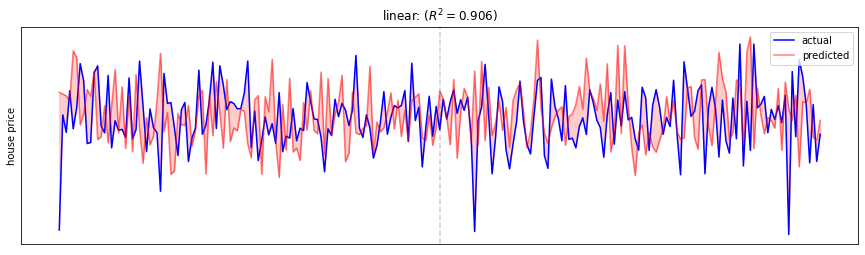

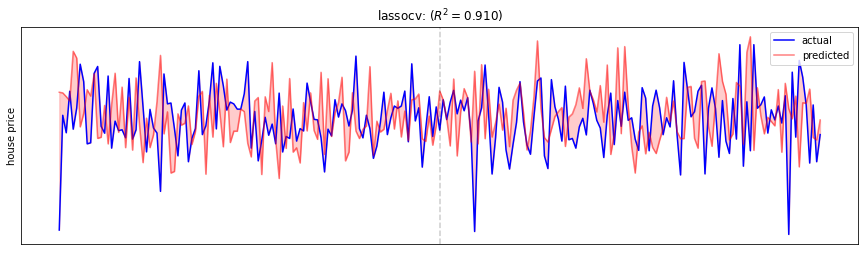

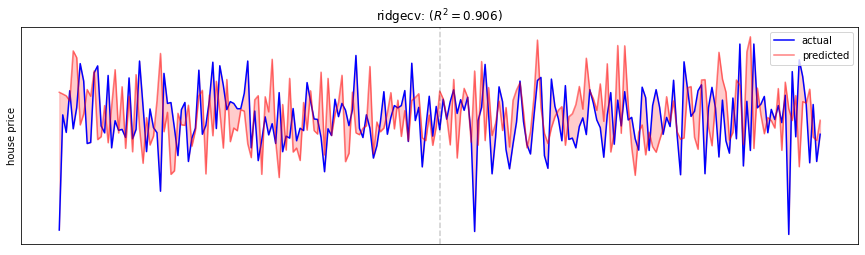

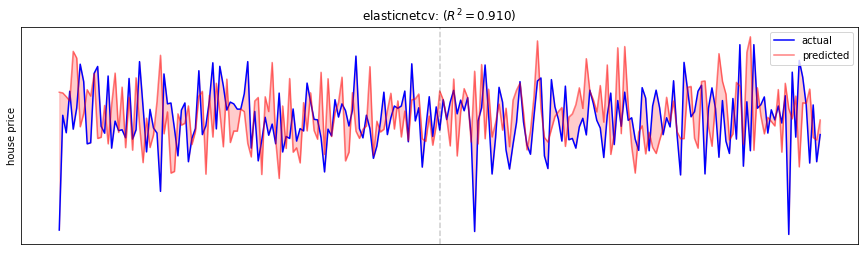

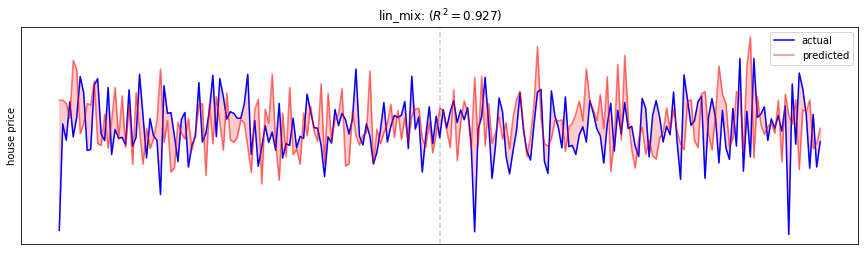

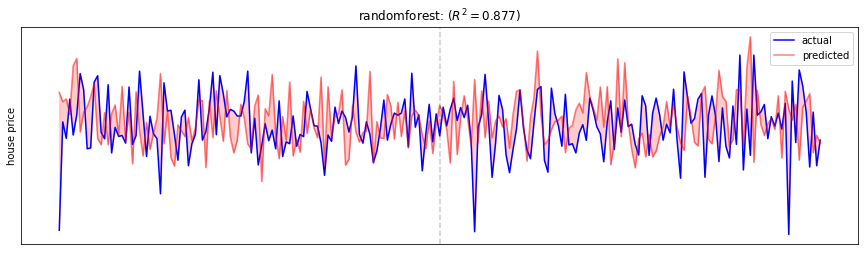

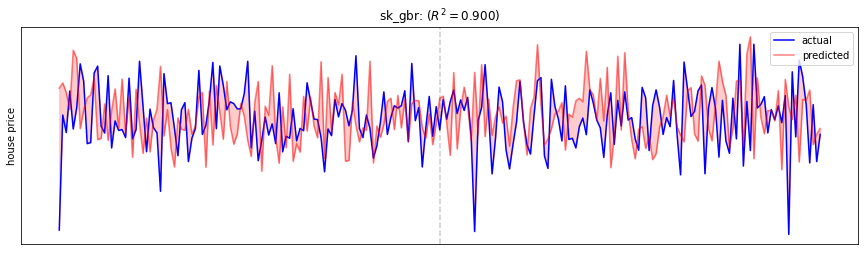

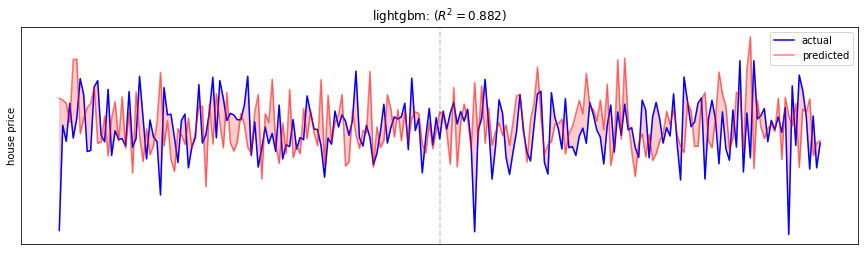

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


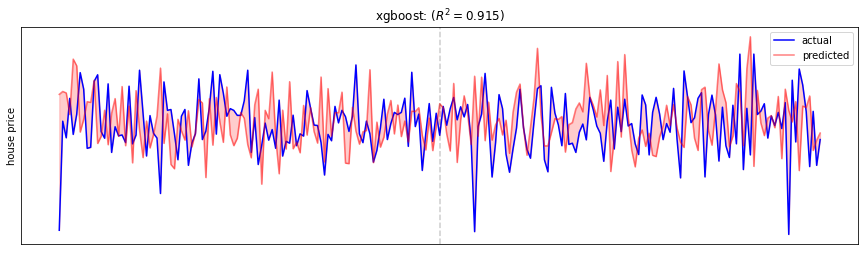

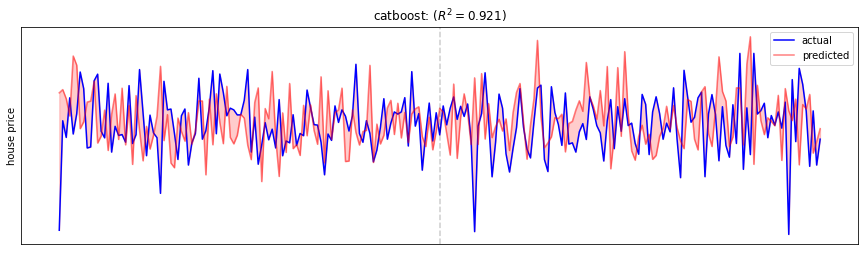

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


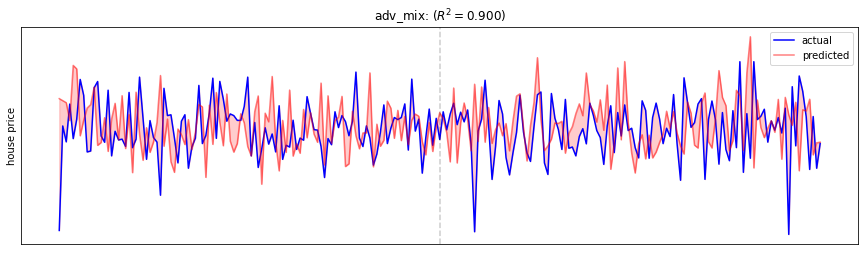

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


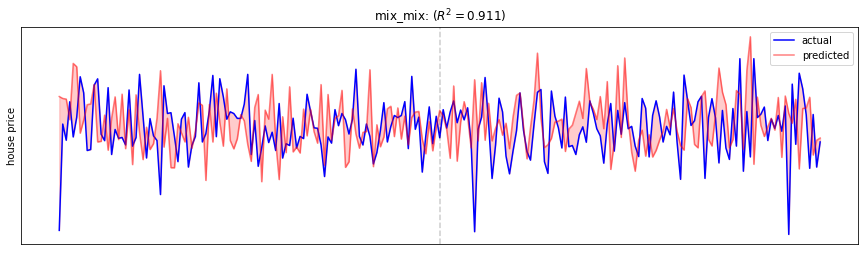

In [319]:
for model in models:
    y_pred = models[model].predict(X_val)
    r_2 = models[model].score(X_val, y_val)
    title = model + ': ($R^2={:.3f}$)'.format(r_2)
    
    #set the figure size
    plt.figure(figsize=(15,4))
    # Configure each plot to have no tick marks
    # (these are meaningless for the sample dataset)
    plt.xticks(())
    plt.yticks(())

    # Label the vertical axis
    plt.ylabel('house price')

    # Set the title for the subplot
    plt.title(title)

    # Plot the actual data and the prediction
    plt.plot(y, 'b', label='actual')
    plt.plot(y_pred, 'r', label='predicted', alpha=0.5)
        
    # Shade the area between the predicted and the actual values
    plt.fill_between(
        # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
        np.arange(0, len(y), 1),
        y,
        y_pred,
        color='r',
        alpha=0.2)

    # Mark the extent of the training data
    plt.axvline(len(y) // 2, linestyle='--', color='black', alpha=0.2)

    # Include a legend in each subplot
    plt.legend()
    # ==================================
    # Display the plot in interactive UI
    plt.show()

In [365]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

best_model = 'mix_mix'
models[best_model].fit(X,y)
pred = models[best_model].predict(X_test)
output['SalePrice'] = np.exp(pred)
output.to_csv('submission13.csv', index=False)

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [367]:
frame  = pd.read_csv('train_featured1.csv')
test_frame = pd.read_csv('test_featured1.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)

Processing 1460 samples with 158 attributes


Evaluating regression learners...
Plotting the results


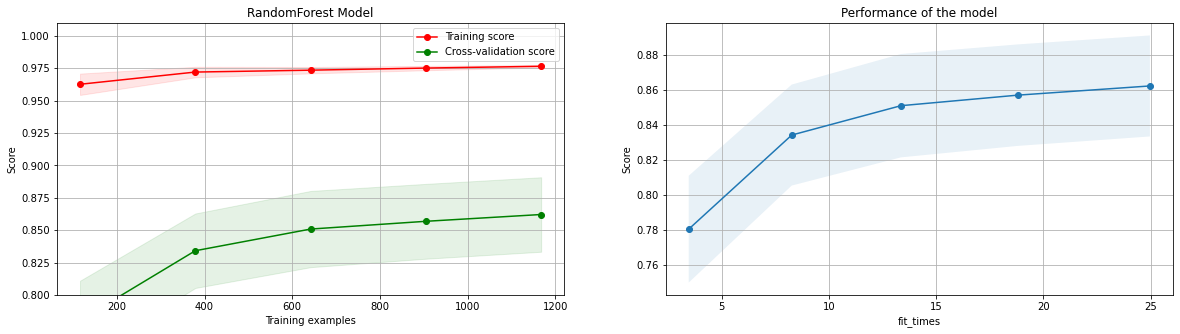

('RandomForest Model ($R^2=0.904$)', array([11.79810441, 11.8493977 , 11.1331281 , 12.50617724, 12.13725833,
       12.36307639, 12.31268238, 11.90158345, 11.97035031, 12.00150548,
       12.10071213, 12.15477935, 12.17818744, 12.22096126, 11.60823564,
       12.14153412, 12.07823927, 12.06681058, 11.89818787, 11.85651517,
       11.48246626, 12.23076526, 12.23999086, 12.33710091, 11.95761129,
       11.7745202 , 11.84222921, 11.96356787, 12.20918779, 12.30817787,
       11.96400108, 12.58819065, 11.86358234, 12.44508955, 11.94470788,
       11.88379913, 11.65268741, 12.32341114, 11.76756768, 12.14153412,
       11.00209984, 11.48246626, 11.60367983, 11.29601246, 12.11724143,
       12.43153351, 12.35879373, 11.77528973, 11.99535161, 11.77143616,
       12.27792808, 12.55483688, 11.88103479, 11.49272276, 12.20607265,
       11.34922937, 11.60823564, 12.12757042, 11.80881377, 12.13296417,
       11.6307085 , 12.52452638, 11.45899712, 11.88448902, 12.00762171,
       12.72188581, 11.1124

In [369]:
# Evaluate multiple regression learners on the data
print("Evaluating regression learners...")
print("Plotting the results")
results = list(evaluate_learner(X_train, X_val, y_train, y_val, X_test, learning_curves=True))

# Display the results
print(results[0][0])

Evaluating regression learners...
Plotting the results


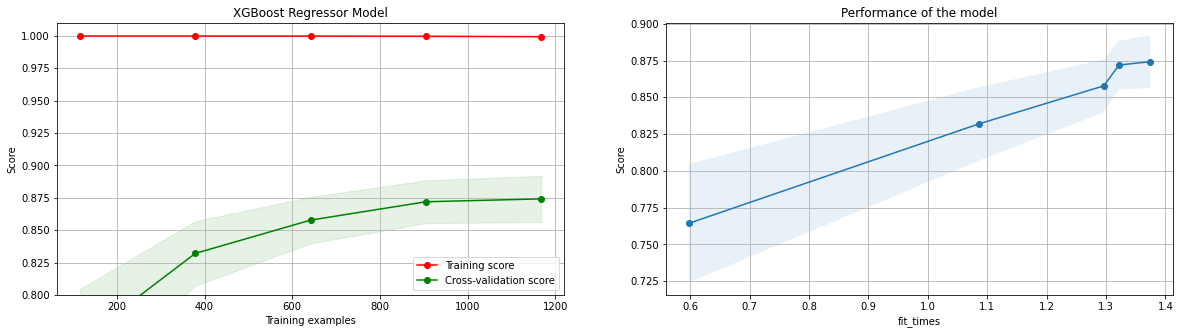

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


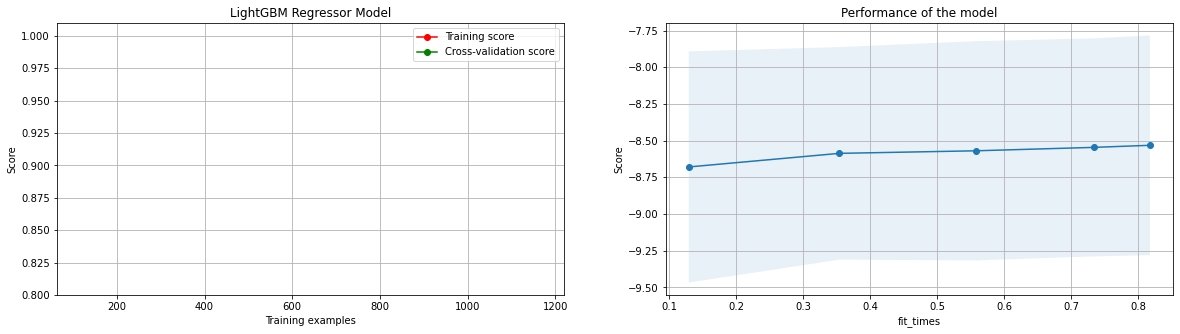

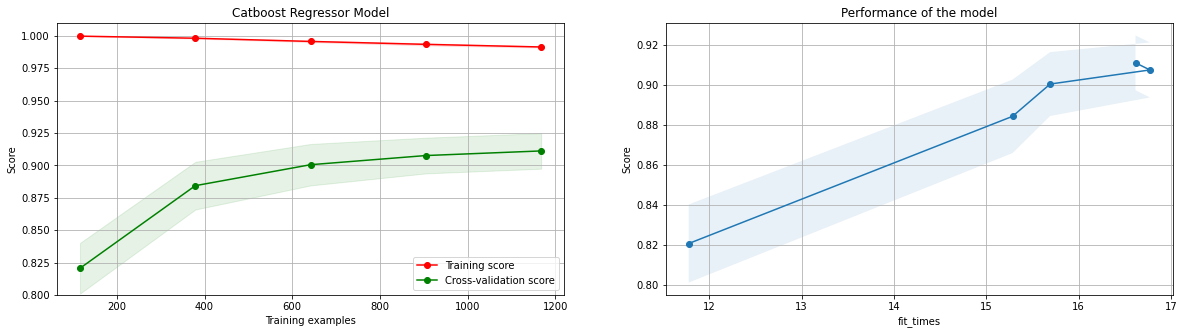

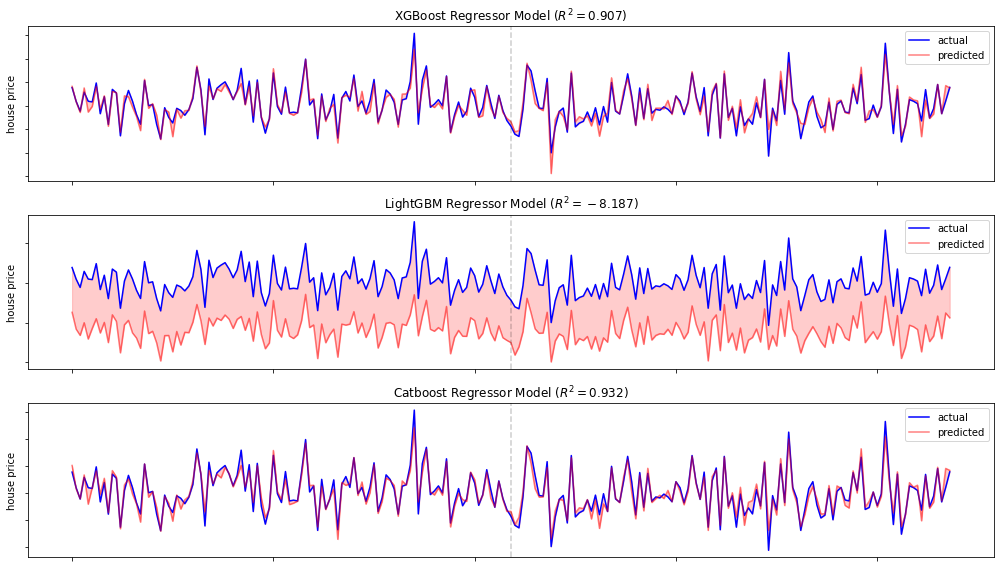

In [334]:
# Evaluate multiple regression learners on the data
print("Evaluating regression learners...")
print("Plotting the results")
results = list(gb_models(X_train, X_val, y_train, y_val, X_test, learning_curves=True))

# Display the results
plot(results)

In [335]:
i = 0
for title, y, y_pred, pred in results:
    if i == 2:
        output['SalePrice'] = pred
    i+=1
output['SalePrice'] = np.exp(output.SalePrice)

In [337]:
output.to_csv('submission11.csv', index=False)

In [338]:
from catboost import CatBoostRegressor, Pool
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))
cbr = CatBoostRegressor(verbose=0)
cbr.fit(X, y)
pred = cbr.predict(X_test)
r_2 = cbr.score(X_val, y_val)
print(r_2)

0.990791952794477


In [339]:
output['SalePrice'] = pred
output['SalePrice'] = np.exp(output.SalePrice)
output.to_csv('submission12.csv', index=False)

In [346]:
models={}
#Reading data
frame  = pd.read_csv('train_featured1.csv')
test_frame = pd.read_csv('test_featured1.csv')
output = pd.DataFrame(test_frame['Id'])
# Process data into feature and label arrays
print("Processing {} samples with {} attributes".format(len(frame.index), len(frame.columns)))
X_train, X_val, y_train, y_val, X_test = get_features_and_labels(frame, test_frame)

Processing 1460 samples with 158 attributes


## Linear Models

### Linear Regression

In [347]:
name = 'linear'
models[name] = LinearRegression()
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Linear Regression: R^2={:.3f}'.format(r_2))

Linear Regression: R^2=0.896


### LassoCV Regression

In [348]:
name = 'lassocv'
grid = {"alphas":np.arange(0.0001,0.001,0.00001)}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = LassoCV(cv=cv, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('LassoCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 0.00099
LassoCV Regression: R^2=0.901


### RidgeCV Regression

In [349]:
name = 'ridgecv'
grid = {"alphas":np.arange(2,2.2,0.001)}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = RidgeCV(cv=cv, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('RidgeCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 2.199999999999978
RidgeCV Regression: R^2=0.896


### ElasticNet Regression

In [350]:
name = 'elasticnetcv'
grid = {"alphas" : np.arange(0.0001,0.001,0.00005),
         "l1_ratio" : [.1, .5, .7, .9, .95, .96, .97,.98, .99, 1]}
cv = ShuffleSplit(n_splits=20, test_size=0.2, random_state=0)
models[name] = ElasticNetCV(cv=cv, max_iter=1e5, **grid)
models[name].fit(X_train, y_train)
print(f"alpha for the best model: {models[name].alpha_}")
r_2 = models[name].score(X_val, y_val)
print('ElasticNetCV Regression: R^2={:.3f}'.format(r_2))

alpha for the best model: 0.0009500000000000002
ElasticNetCV Regression: R^2=0.901


### Linear Mixture Regression

In [351]:
name = "lin_mix"
names = ["elasticnetcv","ridgecv","lassocv","linear"]
models[name] = StackingCVRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=CatBoostRegressor(verbose=False),
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Linear Mixture Regression: R^2={:.3f}'.format(r_2))

Linear Mixture Regression: R^2=0.908


## Advance Regression Models

### RandomForest Regression

In [373]:
name = 'randomforest'
models[name] = RandomForestRegressor(n_estimators=500)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Random Forest Regression: R^2={:.3f}'.format(r_2))

Random Forest Regression: R^2=0.903


### GradientBoostingRegressor

In [377]:
name = 'sk_gbr'
params = {'learning_rate': 0.06700000000000003,'max_depth': 6,'min_samples_leaf': 25,'min_samples_split': 50,'subsample': 0.75}
models[name] = GradientBoostingRegressor(verbose=False,random_state=0, loss='huber', **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Gradient Boosting Regression: R^2={:.3f}'.format(r_2))

Gradient Boosting Regression: R^2=0.914


### LightGBM Regression

In [372]:
name = 'lightgbm'
params = {'learning_rate': 0.018999999999999996,'min_child_samples': 20,'min_split_gain': 0,
          'n_estimators': 500,'reg_alpha': 0.03,'reg_lambda': 0.02,'subsample': 0.75}
models[name] = LGBMRegressor(silent=True, random_state=0, max_depth=-1, **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('LightGBM Regression: R^2={:.3f}'.format(r_2))

LightGBM Regression: R^2=0.925


### XGBoost Regression

In [371]:
name = 'xgboost'
params = {'learning_rate': 0.02299,'max_depth': 6,'n_estimators': 500,'reg_alpha': 0.001,'reg_lambda': 0.41,'subsample': 0.5}
models[name] = XGBRegressor(random_state=0, **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('XGBoost Regression: R^2={:.3f}'.format(r_2))

XGBoost Regression: R^2=0.926


### CatBoost Regression

In [370]:
name = 'catboost'
params = {'eta': 0.02299,'n_estimators': 500,'reg_lambda': 0.41}
models[name] = CatBoostRegressor(verbose=False, **params)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('CatBoost Regression: R^2={:.3f}'.format(r_2))

CatBoost Regression: R^2=0.933


### Advance Mixture Regression

In [382]:
name = "adv_mix"
names = ["xgboost","lightgbm","sk_gbr","randomforest"]
models[name] = StackingRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=models['catboost'],
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Advanced Mixture Regression: R^2={:.3f}'.format(r_2))

Advanced Mixture Regression: R^2=0.930


### Custom Mixture

In [380]:
name = "cus_mix"
names = ["xgboost","lightgbm"]
models[name] = StackingRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=models['catboost'],
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Custom Mixture Regression: R^2={:.3f}'.format(r_2))

Custom Mixture Regression: R^2=0.931


### Mixture of Mixtures

In [358]:
name = "mix_mix"
names = ["lin_mix","adv_mix"]
models[name] = StackingRegressor(regressors= set(models[k] for k in names),
                                   meta_regressor=CatBoostRegressor(verbose=False),
                                   use_features_in_secondary=True)
models[name].fit(X_train, y_train)
r_2 = models[name].score(X_val, y_val)
print('Mixture of Mixtures: R^2={:.3f}'.format(r_2))

Mixture of Mixtures: R^2=0.910


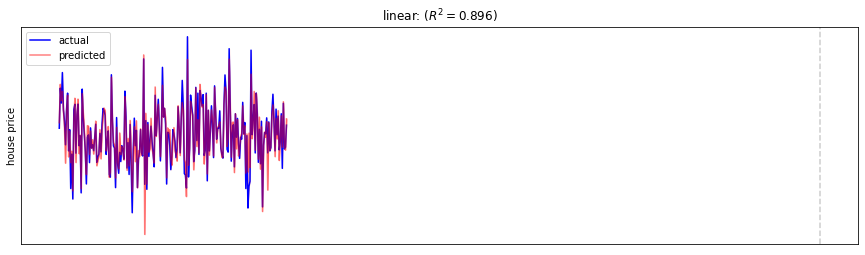

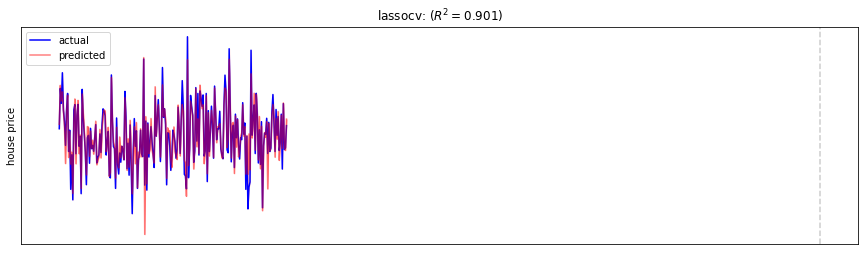

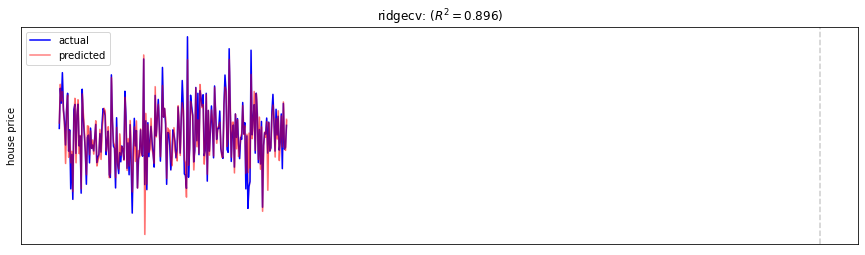

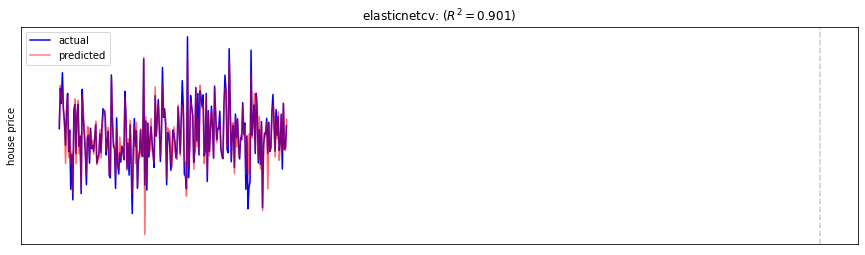

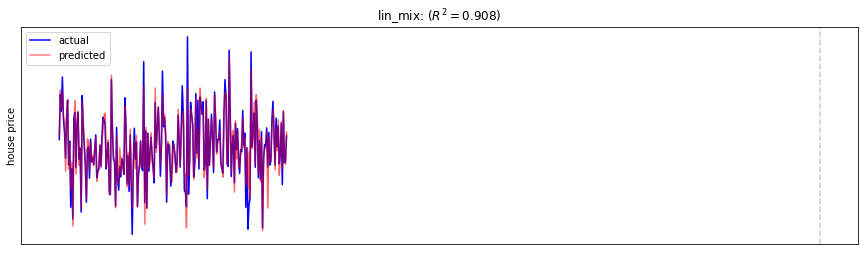

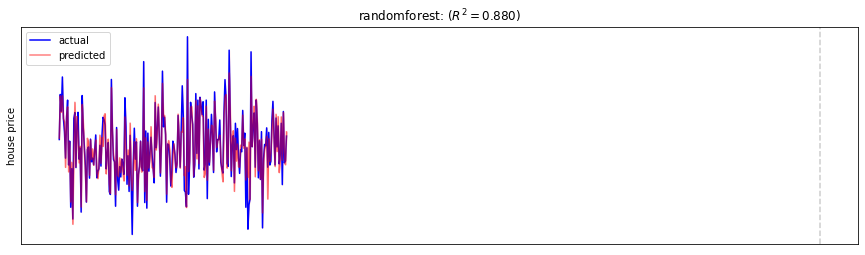

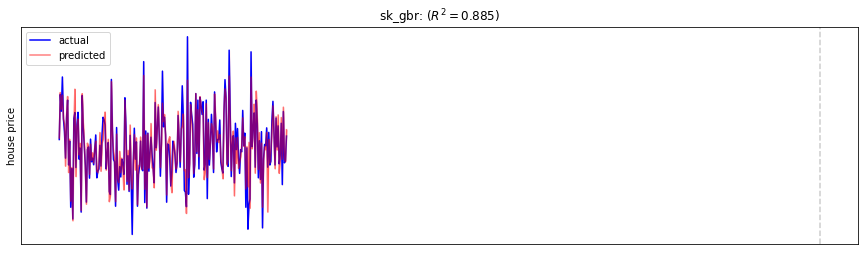

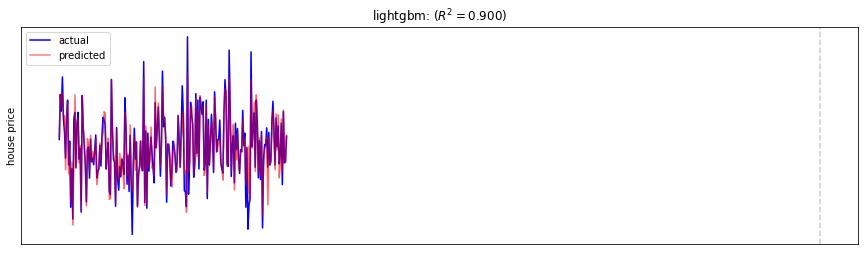

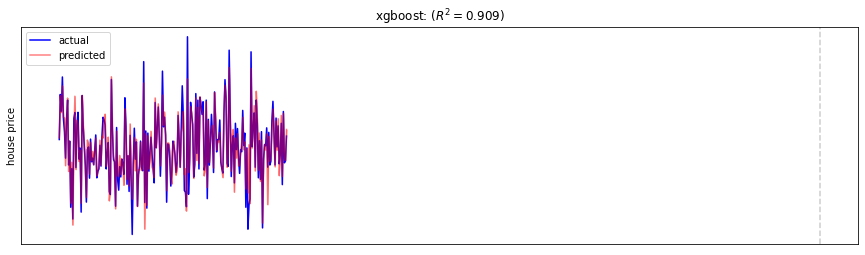

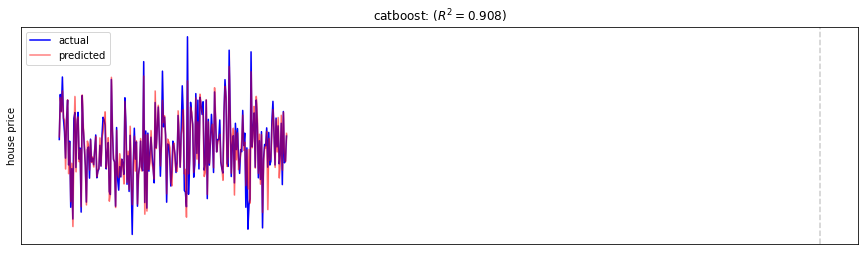

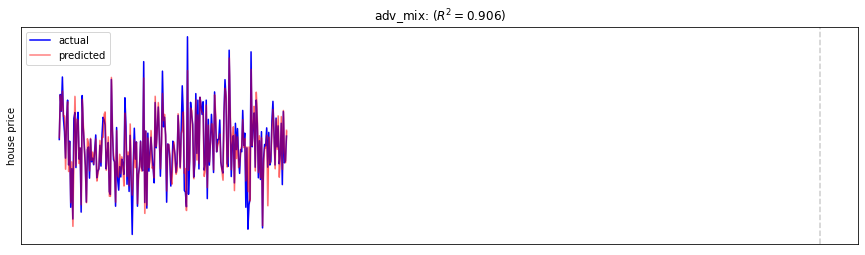

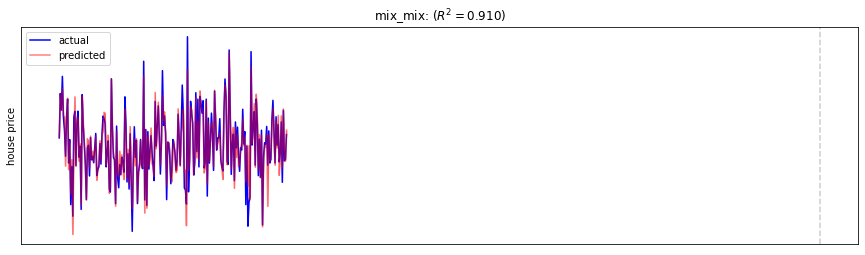

In [361]:
for model in models:
    y_pred = models[model].predict(X_val)
    r_2 = models[model].score(X_val, y_val)
    title = model + ': ($R^2={:.3f}$)'.format(r_2)
    
    #set the figure size
    plt.figure(figsize=(15,4))
    # Configure each plot to have no tick marks
    # (these are meaningless for the sample dataset)
    plt.xticks(())
    plt.yticks(())

    # Label the vertical axis
    plt.ylabel('house price')

    # Set the title for the subplot
    plt.title(title)

    # Plot the actual data and the prediction
    plt.plot(y, 'b', label='actual')
    plt.plot(y_pred, 'r', label='predicted', alpha=0.5)
        
    # Shade the area between the predicted and the actual values
    plt.fill_between(
        # Generate X values [0, 1, 2, ..., len(y)-2, len(y)-1]
        np.arange(0, len(y_val), 1),
        y,
        y_pred,
        color='r',
        alpha=0.2)

    # Mark the extent of the training data
    plt.axvline(len(y) // 2, linestyle='--', color='black', alpha=0.2)

    # Include a legend in each subplot
    plt.legend()
    # ==================================
    # Display the plot in interactive UI
    plt.show()

In [387]:
X = np.concatenate((X_train, X_val))
y = np.concatenate((y_train, y_val))

best_model = 'adv_mix'
models[best_model].fit(X,y)
pred = models[best_model].predict(X_test)
output['SalePrice'] = np.exp(pred)
output.to_csv('submission14.csv', index=False)

C:\Users\Sarda\anaconda3\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(
